# Notes on implementing an effective duty cycle in DC2

This notebook sketches a proposed fix to the root cause of the AGN problem in the DC2 image simulations. The notebook demonstrates the behavior of the duty cycle model, as well as how to modify the behavior in an easily controllable way. If you want to inspect how the DC2+duty-cycle mock catalog looks, you can apply the `calculate_quasar_probability` function described below together with the DC2 composite catalog on NERSC:

/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_mean_mags.h5


### Background

In the generation of the DC2 catalog, every galaxy was assigned a point-source component to its flux. The brightness of this point-source component was determined by a luminosity-black hole model calibrated against a population of quasars. Thus, in effect, the DC2 catalog modeled every galaxy in the universe to be a QSO.

The proposed fix implements a QSO "duty cycle" on top of the existing model; the duty cycle specifies what fraction of the time a black hole spends in a phase when it shines in the optical like a QSO. Very specifically, by "duty cycle" what we actually mean is the fraction of black holes for which a QSO-like flux component will be added. This notebook shows how the `calculate_quasar_probability` function implements this behavior. 


In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np 

### Color-dependence of $P_{\rm qso}$

The `calculate_quasar_probability` function calculates $P_{\rm qso},$ the probability that a galaxy hosts a quasar. The quantity $P_{\rm qso}$ depends on $M_{\star},$ redshift, and $g-r$ and $r-i$ in the restframe. This first plot shows how `calculate_quasar_probability` depends on both $g-r$ and $r-i.$ We look at this dependence separately for both $z=0$ and $z=2.$ We show plots for $M_{\star}=10^{11}M_{\odot},$ but the color-dependence is $M_{\star}-$independent, as we will see in the other plots below. 

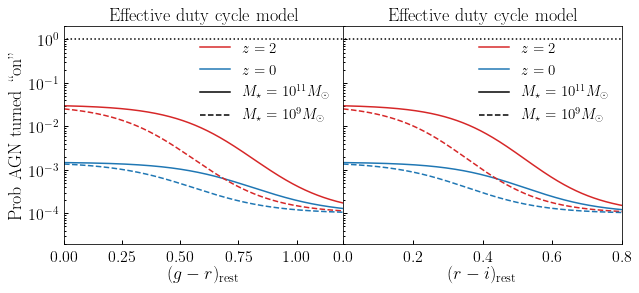

In [3]:
from agn_effective_duty_cycle import calculate_quasar_probability

ngals = int(1e4)
gr_restframe = np.linspace(0, 1.25, ngals)
ri_restframe = np.linspace(0, 0.8, ngals)
prob_z0_m9 = calculate_quasar_probability(10**9, 0., gr_restframe, ri_restframe)
prob_z2_m9 = calculate_quasar_probability(10**9, 2, gr_restframe, ri_restframe)
prob_z0_m11 = calculate_quasar_probability(10**11, 0., gr_restframe, ri_restframe)
prob_z2_m11 = calculate_quasar_probability(10**11, 2, gr_restframe, ri_restframe)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
xlim0 = ax0.set_xlim(0, 1.2)
xlim0 = ax1.set_xlim(0, 0.80)

__=fig.subplots_adjust(wspace=0)  #  smash left and right plots
yscale = ax0.set_yscale('log')
yscale = ax1.set_yscale('log')
ylim = ax0.set_ylim(2e-5, 2)
__=ax0.plot(gr_restframe, prob_z2_m11, label=r'$z=2$', color=mred)
__=ax0.plot(gr_restframe, prob_z0_m11, label=r'$z=0$', color=mblue)
__=ax0.plot(gr_restframe, prob_z2_m9, '--', 
            color=mred, label=r'$M_{\star}=10^{11}M_{\odot}$')
__=ax0.plot(gr_restframe, prob_z0_m9, '--', 
            color=mblue, label=r'$M_{\star}=10^{9}M_{\odot}$')

_=ax1.plot(ri_restframe, prob_z2_m11, label=r'$z=2$', color=mred)
_=ax1.plot(ri_restframe, prob_z0_m11, label=r'$z=0$', color=mblue)
__=ax1.plot(ri_restframe, prob_z2_m9, '--', 
            color=mred, label=r'$M_{\star}=10^{11}M_{\odot}$')
__=ax1.plot(ri_restframe, prob_z0_m9, '--', 
            color=mblue, label=r'$M_{\star}=10^{9}M_{\odot}$')

xlabel = ax0.set_xlabel(r'$(g-r)_{\rm rest}$')
xlabel = ax1.set_xlabel(r'$(r-i)_{\rm rest}$')
ylabel = ax0.set_ylabel(r'${\rm Prob\ AGN\ turned\ ``on"}$')
leg0 = ax0.legend()
leg1 = ax1.legend()
title0 = ax0.set_title(r'${\rm Effective\ duty\ cycle\ model}$')
title0 = ax1.set_title(r'${\rm Effective\ duty\ cycle\ model}$')

leg0.legendHandles[2].set_color('k')
leg0.legendHandles[2].set_linestyle('-')
leg0.legendHandles[3].set_color('k')

leg1.legendHandles[2].set_color('k')
leg1.legendHandles[2].set_linestyle('-')
leg1.legendHandles[3].set_color('k')

__=ax0.plot(np.linspace(-1, 2, 1000), np.ones(1000), ':', color='k')
__=ax1.plot(np.linspace(-1, 2, 1000), np.ones(1000), ':', color='k')
fig.savefig('prob_qso_demo.png', bbox_extra_artists=[xlabel, ylabel], 
            bbox_inches='tight', dpi=200)


Notice that red galaxies have very low probability of hosting a quasar. Also notice how the $z-$dependence of the model only pertains to blue galaxies, such that $P_{\rm qso}$ increases for blue galaxies at higher redshift, but there is no redshift-dependence to $P_{\rm qso}$ for quenched galaxies: at all redshift, red-sequence galaxies have $P_{\rm qso}\approx0.01\%.$ Internally, the function defines an eigencolor as a linear combination of $g-r$ and $r-i,$ so that these dependencies are simultaneously implemented in both restframe bands. 

The next figure shows how the main sequence model parameters modify the behavior of the `calculate_quasar_probability` function. Very briefly, for blue galaxies the value for $P_{\rm qso}$ is defined at low- and high-redshift by two model parameters. Then a simple sigmoid interpolation is used to stitch together these limiting behaviors in a smooth way. The plot shows $g-r,$ but the behavior is the same for $r-i.$

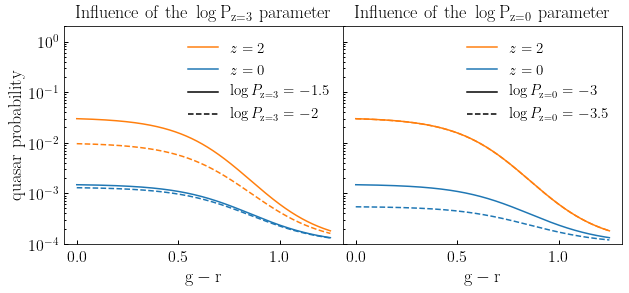

In [4]:
from agn_effective_duty_cycle import calculate_quasar_probability

ngals = int(1e4)
stellar_mass = 10**11.
redshift = 0.
gr_restframe = np.linspace(0, 1.25, ngals)
ri_restframe = np.linspace(0, 0.6, ngals)
prob_z0 = calculate_quasar_probability(stellar_mass, redshift, gr_restframe, ri_restframe,
                                      main_sequence_logprob_hiz=-1.5,
                                      main_sequence_logprob_z0=-3)
prob_z2 = calculate_quasar_probability(stellar_mass, 2, gr_restframe, ri_restframe,
                                      main_sequence_logprob_hiz=-1.5,
                                      main_sequence_logprob_z0=-3)

prob_z0b = calculate_quasar_probability(stellar_mass, redshift, gr_restframe, ri_restframe,
                                       main_sequence_logprob_hiz=-2,
                                      main_sequence_logprob_z0=-3)
prob_z2b = calculate_quasar_probability(stellar_mass, 2, gr_restframe, ri_restframe,
                                       main_sequence_logprob_hiz=-2,
                                      main_sequence_logprob_z0=-3)

prob_z0c = calculate_quasar_probability(stellar_mass, redshift, gr_restframe, ri_restframe,
                                       main_sequence_logprob_hiz=-1.5,
                                      main_sequence_logprob_z0=-3.5)
prob_z2c = calculate_quasar_probability(stellar_mass, 2, gr_restframe, ri_restframe,
                                       main_sequence_logprob_hiz=-1.5,
                                      main_sequence_logprob_z0=-3.5)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
__=fig.subplots_adjust(wspace=0)  #  smash left and right plots
yscale = ax0.set_yscale('log')
ylim = ax0.set_ylim(1e-4, 2)

__=ax0.plot(gr_restframe, prob_z2, label=r'$z=2$', color=morange)
__=ax0.plot(gr_restframe, prob_z0, label=r'$z=0$', color=mblue)
__=ax0.plot(gr_restframe, prob_z0b, '--', label=r'$\log P_{\rm z=3}=-1.5$', color=mblue)
__=ax0.plot(gr_restframe, prob_z2b, '--', label=r'$\log P_{\rm z=3}=-2$', color=morange)

__=ax1.plot(gr_restframe, prob_z2, label=r'$z=2$', color=morange)
__=ax1.plot(gr_restframe, prob_z0, label=r'$z=0$', color=mblue)
__=ax1.plot(gr_restframe, prob_z0c, '--', label=r'$\log P_{\rm z=0}=-3$', color=mblue)
__=ax1.plot(gr_restframe, prob_z2c, '--', label=r'$\log P_{\rm z=0}=-3.5$', color=morange)


xlabel = ax0.set_xlabel(r'${\rm g-r}$')
xlabel = ax1.set_xlabel(r'${\rm g-r}$')
ylabel = ax0.set_ylabel(r'${\rm quasar\ probability}$')
leg0 = ax0.legend()
leg1 = ax1.legend()

title = ax0.set_title(r'${\rm Influence\ of\ the\ \log P_{\rm z=3}\ parameter}$')
title = ax1.set_title(r'${\rm Influence\ of\ the\ \log P_{\rm z=0}\ parameter}$')

leg0.legendHandles[2].set_color('k')
leg0.legendHandles[2].set_linestyle('-')
leg0.legendHandles[3].set_color('k')

leg1.legendHandles[2].set_color('k')
leg1.legendHandles[2].set_linestyle('-')
leg1.legendHandles[3].set_color('k')


In the left panel, we change $\log P_{\rm z=3},$ which only appreciably modifies the high-redshift value of $P_{\rm qso}$ for main sequence galaxies, but leaves the $z=0$ galaxies alone. On the other hand, in the right panel we change $\log P_{\rm z=0},$ which conversely changes the QSO probability only for main sequence galaxies at low redshift.

### $M_{\star}-$dependence of $P_{\rm qso}$

At fixed $g-r$ and $r-i$ color, the $P_{\rm qso}$ function has no dependence upon stellar mass. We'll see that in the plot below. Note, though, that in this model high-mass galaxies will still have very low probability of hosting a quasar, because most high-mass galaxies are quenched. 

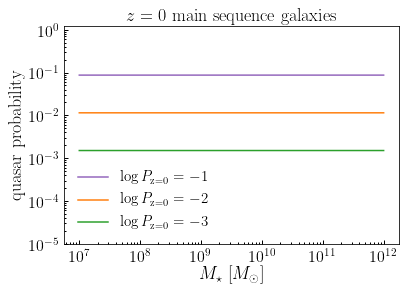

In [5]:
from agn_effective_duty_cycle import calculate_quasar_probability

ngals = int(1e4)
stellar_mass = np.logspace(7, 12, ngals)
redshift = 0.
gr_restframe = -100 # Setting color to ultra-blue effectively selects the behavior at top of the main sequence
ri_restframe = -100 # Setting color to ultra-blue effectively selects the behavior at top of the main sequence
prob = calculate_quasar_probability(stellar_mass, redshift, gr_restframe, ri_restframe)
prob2 = calculate_quasar_probability(stellar_mass, redshift, gr_restframe, ri_restframe, 
                                    main_sequence_logprob_z0=-2)
prob3 = calculate_quasar_probability(stellar_mass, redshift, gr_restframe, ri_restframe, 
                                    main_sequence_logprob_z0=-1)

fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
ylim = ax.set_ylim(1e-5, 1.2)
xscale = ax.set_xscale('log')
__=ax.plot(stellar_mass, prob3, label=r'$\log P_{\rm z=0}=-1$', color=mpurple)
__=ax.plot(stellar_mass, prob2, label=r'$\log P_{\rm z=0}=-2$', color=morange)
__=ax.plot(stellar_mass, prob, label=r'$\log P_{\rm z=0}=-3$', color=mgreen)

leg = ax.legend()

xlabel = ax.set_xlabel(r'$M_{\star}\ [M_{\odot}]$')
ylabel = ax.set_ylabel(r'${\rm quasar\ probability}$')
title = ax.set_title(r'$z=0\ {\rm main\ sequence\ galaxies}$')

## Summary of model behavior:

* Internally, the function separates "quenched" and "main sequence" galaxies via an $M_{\star}-$dependent green valley (GV) defined in terms of both $g-r$ and $r-i$ in the restframe.
* Galaxies redwards of the GV cut are assigned a very low $\sim0.01\%$ probability of hosting a quasar; this should ensure that the cluster red sequence is essentially unchanged by the quasar model.
* Galaxies bluewards of the GV cut are assigned a probability to host a quasar that is controllable with two parameters, one for the value of $P_{\rm qso}$ at low redshift, and one for the value at high-redshift. 
* Sigmoid interpolation is used to smoothly transition the behavior of the `calculate_quasar_probability` function between the control points defined by the input model parameters.
* The numerical values of the model parameters have already been coarsely tuned so that, by eye, $P_{\rm qso} < P_{\rm AGN},$ where I have eyeballed $P_{\rm AGN}$ from the top panel of Figure 3 of https://arxiv.org/abs/1810.04683. The model parameters have also been tuned to ensure that $P_{\rm qso}<0.01\%$ for red sequence galaxies of all mass and redshift. 

